## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
houses = pd.read_csv("train.csv")

In [3]:
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Details of the dataset
print(houses.shape)
houses.info()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

## Data Understanding

In [5]:
# MSSubClass: Identifies the type of dwelling involved in the sale.
houses['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [10]:
# MSSubClass is of categorical datatype (as per the data dictionary), hence converting the type
houses['MSSubClass'] = houses['MSSubClass'].astype('object')

In [6]:
# MSZoning: Identifies the general zoning classification of the sale
houses['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
# Alley: Type of alley access to property
houses.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [8]:
# There are only 91 rows having Alley access and rest have No alley access, Hence dropping the column
houses = houses.drop(columns=['Alley'])
houses.shape

(1460, 80)

In [9]:
# id is not required for model build, dropping the column
houses = houses.drop(columns=['Id'])
houses.shape

(1460, 79)

### Missing value imputation, Redundant Column drop

In [11]:
# Checking for null percentage 
null_check = houses.isnull().sum()
round(100*null_check[null_check>0]/len(houses.index),2)

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [12]:
# PoolQC: Pool quality
houses.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [13]:
# Fence: Fence quality
houses.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [14]:
# MiscFeature: Miscellaneous feature not covered in other categories
houses.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [15]:
# Dropping columns having null percentage > 80, as these are not having much information
houses = houses.drop(columns=['PoolQC', 'Fence', 'MiscFeature'])
houses.shape

(1460, 76)

In [16]:
null_check = houses.isnull().sum()
null_check[null_check>0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

### Outlier detection

In [17]:
houses.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [18]:
# LotFrontage: Linear feet of street connected to property
houses.LotFrontage.value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

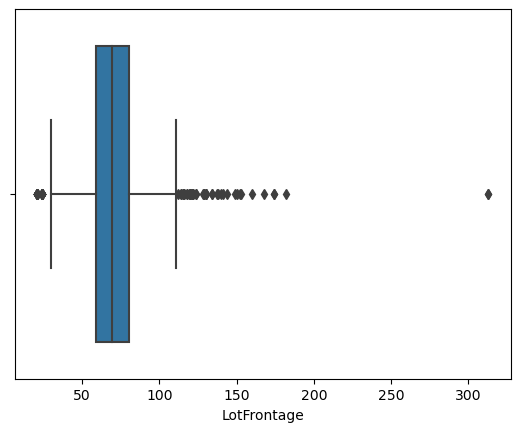

In [19]:
sns.boxplot(x=houses.LotFrontage)
plt.show()

In [20]:
houses[houses.LotFrontage>150].LotFrontage.count()

9

In [21]:
# Dropping coulmns having houses.LotFrontage values more than 150, as there is outlier available 
houses=houses[~(houses.LotFrontage>150)]

In [22]:
# Updating missing value of LotFrontage with median value
houses.LotFrontage = houses.LotFrontage.fillna(houses.LotFrontage.median())

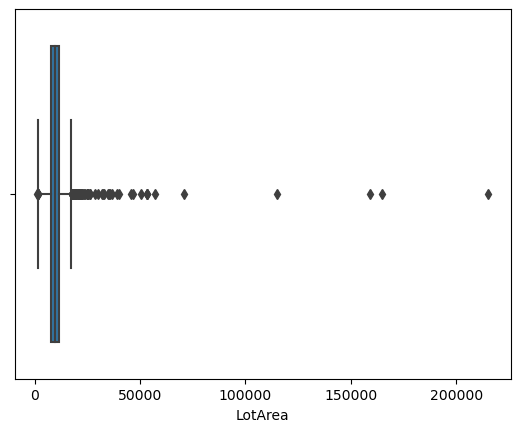

In [23]:
# LotArea: Lot size in square feet
sns.boxplot(x=houses.LotArea)
plt.show()

In [24]:
houses[houses.LotArea>=50000].LotArea.count()

10

In [25]:
# Dropping coulmns having houses.LotArea values more than 50000, as there is outlier available 
houses = houses[houses.LotArea<=50000]
houses.shape

(1441, 76)

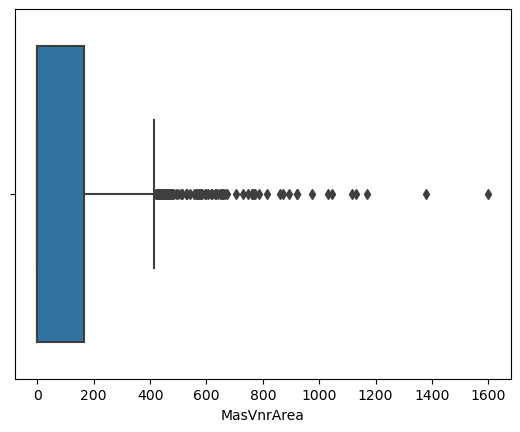

In [26]:
# MasVnrArea: Masonry veneer area in square feet
sns.boxplot(x=houses.MasVnrArea)
plt.show()

In [27]:
houses[houses.MasVnrArea>=1000].MasVnrArea.count()

7

In [28]:
# Dropping coulmns having houses.MasVnrArea values more than 1000, as there is outlier available 
houses=houses[houses.MasVnrArea<1000]
houses.shape

(1426, 76)

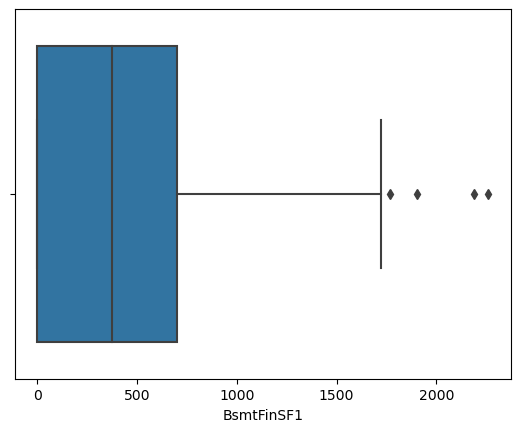

In [29]:
# BsmtFinSF1: Type 1 finished square feet
sns.boxplot(x=houses.BsmtFinSF1)
plt.show()

In [30]:
houses[houses.BsmtFinSF1>1700].BsmtFinSF1.count()

5

In [31]:
houses.select_dtypes(include=['float64', 'int64']).columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

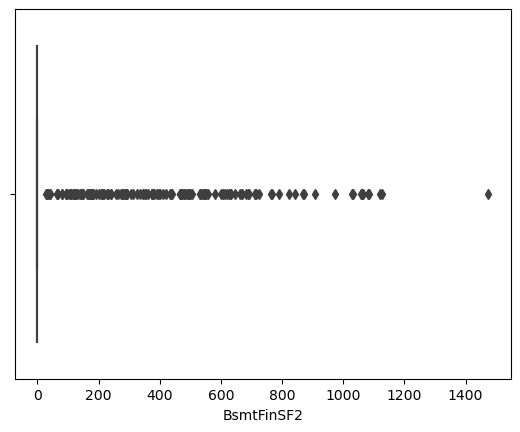

In [32]:
# BsmtFinType2: Rating of basement finished area (if multiple types)
sns.boxplot(x=houses.BsmtFinSF2)
plt.show()

In [33]:
houses.BsmtFinSF2.describe()

count    1426.000000
mean       46.528050
std       161.548583
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

In [34]:
houses.BsmtFinSF2.value_counts()

0       1264
180        5
374        3
469        2
290        2
        ... 
495        1
169        1
532        1
165        1
1029       1
Name: BsmtFinSF2, Length: 140, dtype: int64

In [35]:
# BsmtFinSF2: Type 2 finished square feet
# There are only 143 different data available
# hence dropping the column
houses = houses.drop(columns=['BsmtFinSF2'])
houses.shape

(1426, 75)

In [36]:
# BsmtUnfSF: Unfinished square feet of basement area
houses.BsmtUnfSF.value_counts()

0       118
728       9
384       8
600       7
572       7
       ... 
1257      1
878       1
605       1
467       1
136       1
Name: BsmtUnfSF, Length: 771, dtype: int64

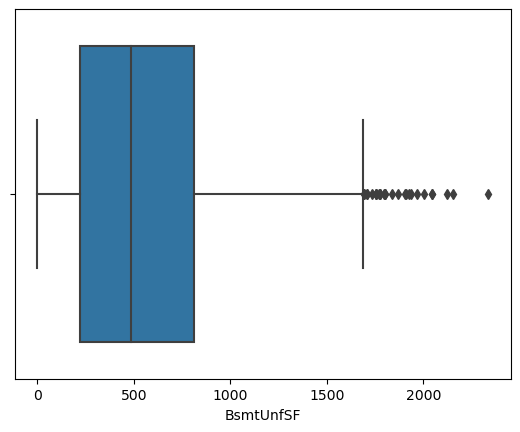

In [37]:
sns.boxplot(x=houses.BsmtUnfSF)
plt.show()

In [38]:
houses.BsmtUnfSF.describe()

count    1426.000000
mean      569.370968
std       443.457732
min         0.000000
25%       223.000000
50%       482.500000
75%       809.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

In [39]:
# TotalBsmtSF: Total square feet of basement area
houses.TotalBsmtSF.describe()

count    1426.000000
mean     1045.830295
std       412.183062
min         0.000000
25%       794.000000
50%       988.000000
75%      1276.000000
max      3206.000000
Name: TotalBsmtSF, dtype: float64

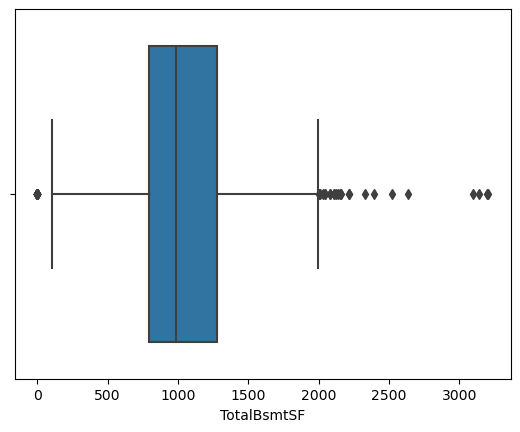

In [40]:
sns.boxplot(x=houses.TotalBsmtSF)
plt.show()

In [41]:
houses[houses.TotalBsmtSF>2200].TotalBsmtSF.count()

10

In [42]:
# Dropping coulmns having houses.TotalBsmtSF values more than 2200, as there is outlier available 
houses=houses[houses.TotalBsmtSF<2200]
houses.shape

(1416, 75)

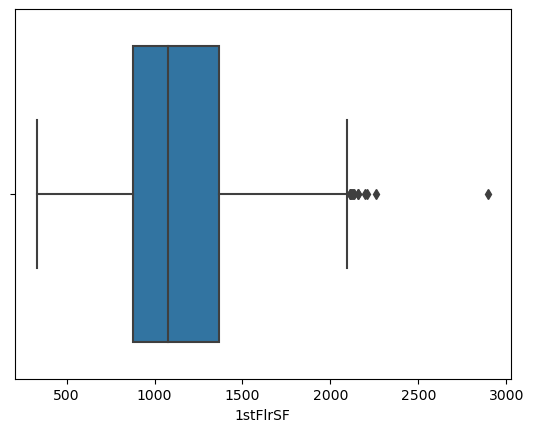

count    1416.000000
mean     1142.698446
std       350.219762
min       334.000000
25%       876.750000
50%      1077.500000
75%      1368.000000
max      2898.000000
Name: 1stFlrSF, dtype: float64

In [43]:
# 1stFlrSF: First Floor square feet
sns.boxplot(x=houses['1stFlrSF'])
plt.show()
houses['1stFlrSF'].describe()

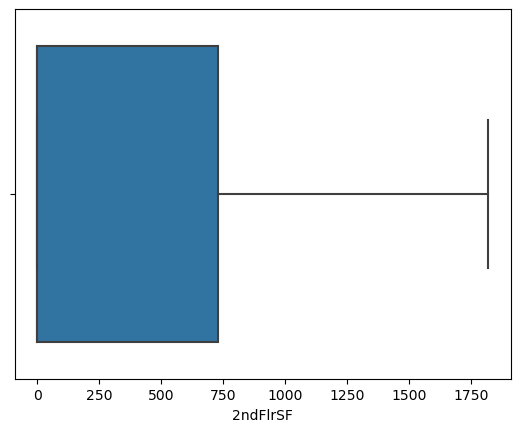

count    1416.000000
mean      342.174435
std       427.119837
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      1818.000000
Name: 2ndFlrSF, dtype: float64

In [44]:
# 2ndFlrSF: Second floor square feet
sns.boxplot(x=houses['2ndFlrSF'])
plt.show()
houses['2ndFlrSF'].describe()

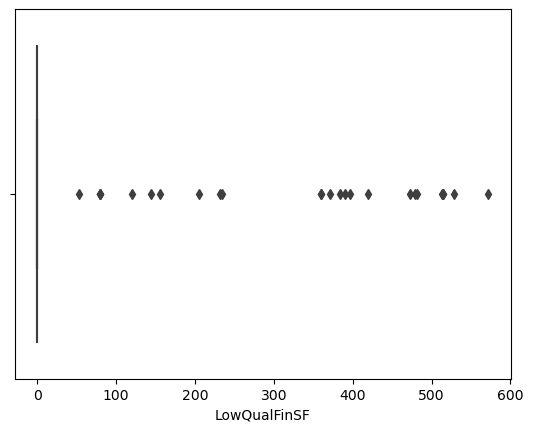

count    1416.000000
mean        5.749294
std        48.283439
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

In [45]:
# LowQualFinSF: Low quality finished square feet (all floors)
sns.boxplot(x=houses['LowQualFinSF'])
plt.show()
houses['LowQualFinSF'].describe()

In [46]:
houses.LowQualFinSF.value_counts()

0      1391
80        3
360       2
515       1
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
156       1
473       1
420       1
390       1
371       1
144       1
572       1
528       1
234       1
513       1
384       1
Name: LowQualFinSF, dtype: int64

In [47]:
# there only 22 different data available for LowQualFinSF, hence dropping the column
houses = houses.drop(columns=['LowQualFinSF'])
houses.shape

(1416, 74)

In [48]:
# GrLivArea: Above grade (ground) living area square feet
houses.GrLivArea.value_counts()

864     22
1040    14
894     11
1456    10
848     10
        ..
2713     1
605      1
827      1
334      1
1256     1
Name: GrLivArea, Length: 831, dtype: int64

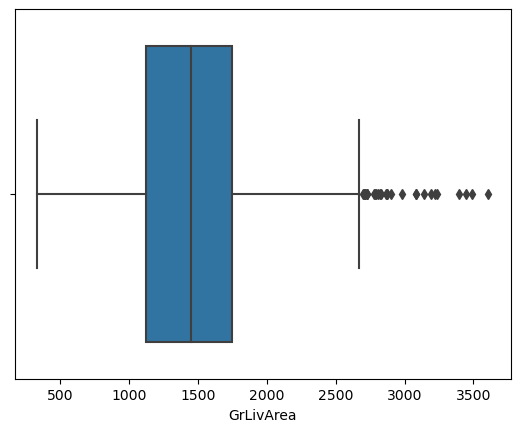

count    1416.000000
mean     1490.622175
std       483.470072
min       334.000000
25%      1123.750000
50%      1449.000000
75%      1750.500000
max      3608.000000
Name: GrLivArea, dtype: float64

In [49]:
sns.boxplot(x=houses['GrLivArea'])
plt.show()
houses['GrLivArea'].describe()

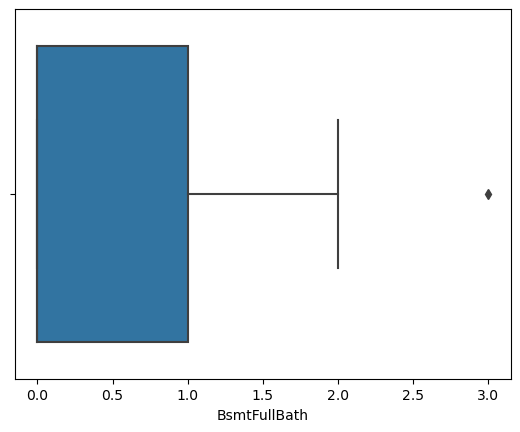

count    1416.000000
mean        0.412429
std         0.512143
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

In [50]:
# BsmtFullBath: Basement full bathrooms
sns.boxplot(x=houses['BsmtFullBath'])
plt.show()
houses['BsmtFullBath'].describe()

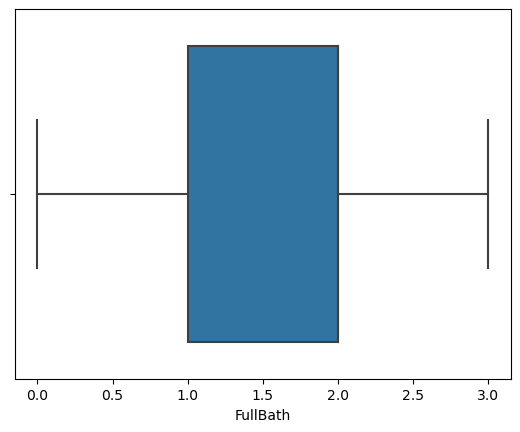

count    1416.000000
mean        1.550847
std         0.542432
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

In [51]:
# FullBath: Full bathrooms above grade
sns.boxplot(x=houses['FullBath'])
plt.show()
houses['FullBath'].describe()

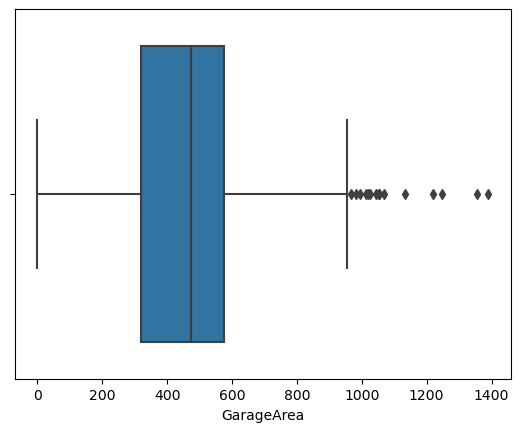

count    1416.000000
mean      467.420198
std       210.888879
min         0.000000
25%       318.750000
50%       474.000000
75%       576.000000
max      1390.000000
Name: GarageArea, dtype: float64

In [53]:
#  GarageArea: Size of garage in square feet
sns.boxplot(x=houses['GarageArea'])
plt.show()
houses['GarageArea'].describe()

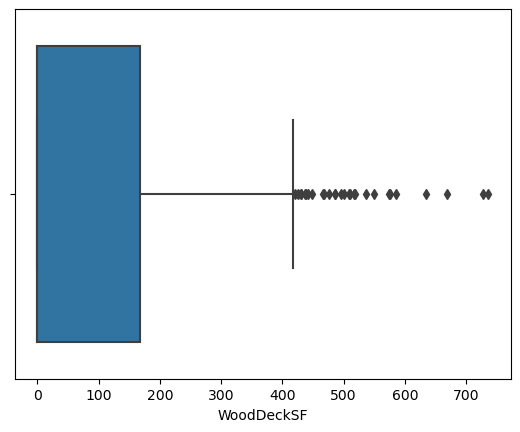

count    1416.000000
mean       92.065678
std       121.621102
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       736.000000
Name: WoodDeckSF, dtype: float64

In [54]:
#  WoodDeckSF: Wood deck area in square feet
sns.boxplot(x=houses['WoodDeckSF'])
plt.show()
houses['WoodDeckSF'].describe()

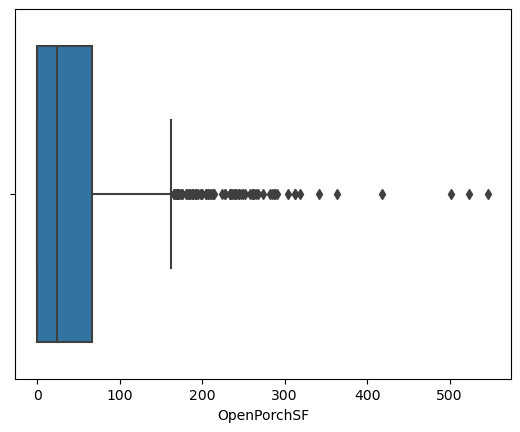

count    1416.000000
mean       45.595339
std        65.180994
min         0.000000
25%         0.000000
50%        24.000000
75%        66.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [55]:
#   OpenPorchSF: Open porch area in square feet
sns.boxplot(x=houses['OpenPorchSF'])
plt.show()
houses['OpenPorchSF'].describe()

In [56]:
houses[houses.OpenPorchSF>=350].OpenPorchSF.count()

5

In [57]:
# Dropping coulmns having houses.OpenPorchSF values more than 350, as there is outlier available 
houses=houses[houses.OpenPorchSF<350]
houses.shape

(1411, 74)

In [58]:
houses.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,...,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000
mean,68.781006,9734.724309,6.049610,5.586109,1970.890149,1984.614458,95.648476,424.136782,564.216867,1033.302622,...,92.170092,44.088590,21.690999,3.527994,14.454288,1.758327,43.333806,6.310418,2007.821403,176458.395464
std,18.779484,4362.799431,1.339664,1.117332,30.195086,20.686451,157.497395,417.930844,438.396181,387.940477,...,121.722837,60.028468,59.565241,29.815385,53.806363,33.276433,503.297364,2.695680,1.329692,71104.964901
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,60.000000,7500.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,219.500000,793.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129000.000000
50%,69.000000,9375.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,371.000000,479.000000,980.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,78.000000,11399.000000,7.000000,6.000000,2000.000000,2004.000000,160.000000,697.000000,803.500000,1268.000000,...,168.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,208700.000000
max,149.000000,46589.000000,10.000000,9.000000,2010.000000,2010.000000,975.000000,1721.000000,2153.000000,2158.000000,...,736.000000,341.000000,386.000000,508.000000,440.000000,738.000000,15500.000000,12.000000,2010.000000,582933.000000


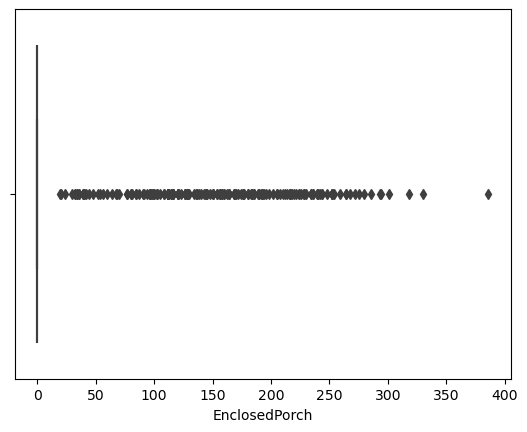

count    1411.000000
mean       21.690999
std        59.565241
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       386.000000
Name: EnclosedPorch, dtype: float64

In [59]:
# EnclosedPorch: Enclosed porch area in square feet
sns.boxplot(x=houses['EnclosedPorch'])
plt.show()
houses['EnclosedPorch'].describe()

In [60]:
houses.EnclosedPorch.value_counts()

0      1210
112      15
96        6
144       5
192       5
       ... 
44        1
293       1
189       1
54        1
99        1
Name: EnclosedPorch, Length: 115, dtype: int64

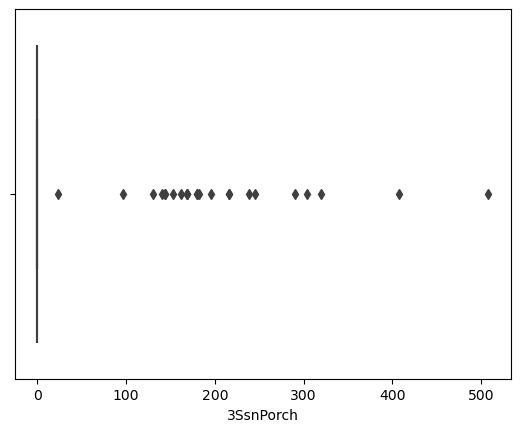

count    1411.000000
mean        3.527994
std        29.815385
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

In [61]:
# 3SsnPorch: Three season porch area in square feet
sns.boxplot(x=houses['3SsnPorch'])
plt.show()
houses['3SsnPorch'].describe()

In [62]:
houses['3SsnPorch'].value_counts()

0      1387
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: 3SsnPorch, dtype: int64

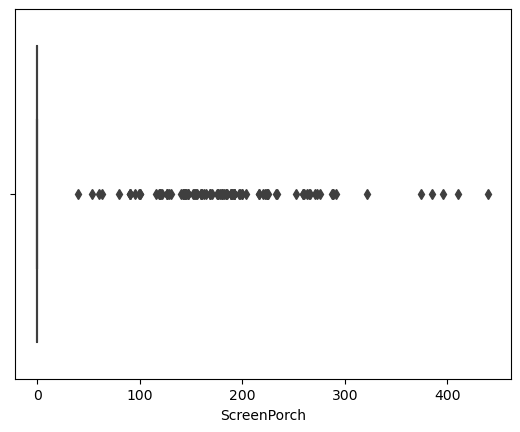

count    1411.000000
mean       14.454288
std        53.806363
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       440.000000
Name: ScreenPorch, dtype: float64

In [63]:
# ScreenPorch: Screen porch area in square feet
sns.boxplot(x=houses['ScreenPorch'])
plt.show()
houses['ScreenPorch'].describe()

In [64]:
houses.ScreenPorch.value_counts()

0      1301
192       6
120       5
189       4
180       4
       ... 
60        1
252       1
260       1
385       1
40        1
Name: ScreenPorch, Length: 73, dtype: int64

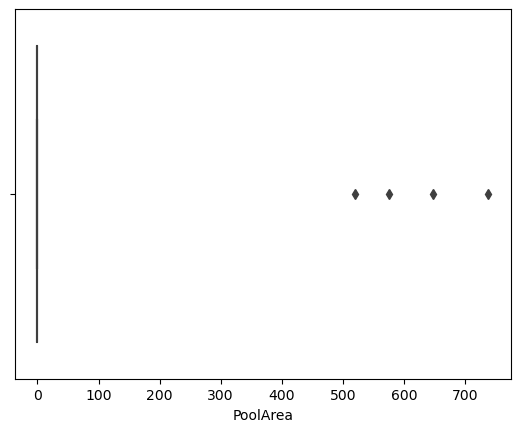

count    1411.000000
mean        1.758327
std        33.276433
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

In [65]:
#   PoolArea: Pool area in square feet
sns.boxplot(x=houses['PoolArea'])
plt.show()
houses['PoolArea'].describe()

In [66]:
houses.PoolArea.value_counts()

0      1407
648       1
576       1
519       1
738       1
Name: PoolArea, dtype: int64

In [67]:
#  PoolArea: Pool area in square feet
# There are only 4 different data available
# hence dropping the column
houses = houses.drop(columns=['PoolArea'])
houses.shape

(1411, 73)

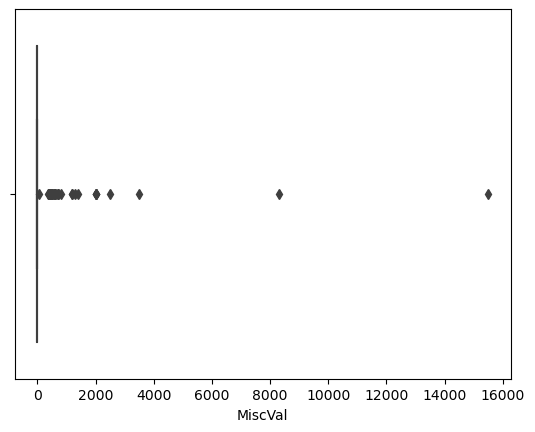

count     1411.000000
mean        43.333806
std        503.297364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

In [68]:
# MiscVal: $Value of miscellaneous feature
sns.boxplot(x=houses['MiscVal'])
plt.show()
houses['MiscVal'].describe()

In [69]:
houses.MiscVal.value_counts()

0        1362
400        11
500         7
450         4
600         4
700         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
2500        1
Name: MiscVal, dtype: int64

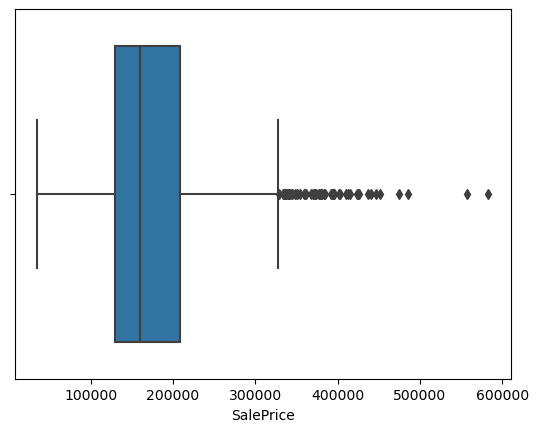

count      1411.000000
mean     176458.395464
std       71104.964901
min       35311.000000
25%      129000.000000
50%      160000.000000
75%      208700.000000
max      582933.000000
Name: SalePrice, dtype: float64

In [71]:
# SalePrice: Response Variable
sns.boxplot(x=houses['SalePrice'])
plt.show()
houses['SalePrice'].describe()

In [72]:
houses[houses.SalePrice>450000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,260,0,0,410,0,6,2006,WD,Normal,475000
591,60,RL,97.0,13478,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,274,0,0,0,0,6,2009,ConLI,Normal,451950
798,60,RL,104.0,13518,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,78,0,0,0,0,7,2009,New,Partial,485000
803,60,RL,107.0,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,170,0,0,192,0,1,2009,New,Partial,582933
1046,60,RL,85.0,16056,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,108,0,0,0,0,7,2006,New,Partial,556581


In [73]:
# MoSold: Month Sold (MM)
houses.MoSold.value_counts()

6     241
7     227
5     201
4     140
8     119
3      99
10     85
11     74
9      61
12     57
1      56
2      51
Name: MoSold, dtype: int64

In [74]:
# YrSold: Year Sold (YYYY)
houses.YrSold.value_counts()

2009    329
2007    313
2006    304
2008    295
2010    170
Name: YrSold, dtype: int64

In [75]:
# MoSold, YrSold are not numeric variables hence converting these to categorical
houses['MoSold'] = houses['MoSold'].astype('object')
houses['YrSold'] = houses['YrSold'].astype('object')

Data understanding, Imputations for categorical data

In [76]:
null_check = houses.isnull().sum()
null_check[null_check>0]

BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     37
Electrical        1
FireplaceQu     683
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
dtype: int64

In [77]:
# For BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : NA value means there is No basement
# Hence updating the value with NoBasement
houses.BsmtQual = houses.BsmtQual.fillna('NoBasement')
houses.BsmtCond = houses.BsmtCond.fillna('NoBasement')
houses.BsmtExposure = houses.BsmtExposure.fillna('NoBasement')
houses.BsmtFinType1 = houses.BsmtFinType1.fillna('NoBasement')
houses.BsmtFinType2 = houses.BsmtFinType2.fillna('NoBasement')

In [78]:
# FireplaceQu: Fireplace quality, NA value means there is No fireplace available
# Hence updating the value with No
houses.FireplaceQu = houses.FireplaceQu.fillna('No')

In [79]:
# For GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond : NA value means there is No Garage
# Hence updating the value with NoBasement
houses.GarageType = houses.GarageType.fillna('No')
houses.GarageYrBlt = houses.GarageYrBlt.fillna('No')
houses.GarageFinish = houses.GarageFinish.fillna('No')
houses.GarageQual = houses.GarageQual.fillna('No')
houses.GarageCond = houses.GarageCond.fillna('No')

In [80]:
null_check = houses.isnull().sum()
null_check[null_check>0]

Electrical    1
dtype: int64

In [81]:
houses.Electrical.value_counts()

SBrkr    1287
FuseA      92
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [82]:
# Filling null Electrical with mode value
houses.Electrical = houses.Electrical.fillna(houses.Electrical.mode()[0])

In [83]:
null_check = houses.isnull().sum()
null_check[null_check>0]

Series([], dtype: int64)

#### Data Preparation 

In [84]:
houses.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorc

In [85]:
# split into X and y
X = houses.loc[:, ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']] 

y = houses['SalePrice']

In [86]:
print(X.shape)
y.shape

(1411, 72)


(1411,)

In [87]:
# creating dummy variables for categorical variables
# subset all categorical variables
houses_categorical = X.select_dtypes(include=['object'])
houses_categorical.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,2003.0,RFn,TA,TA,Y,2,2008,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,1976.0,RFn,TA,TA,Y,5,2007,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,2001.0,RFn,TA,TA,Y,9,2008,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,1998.0,Unf,TA,TA,Y,2,2006,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,2000.0,RFn,TA,TA,Y,12,2008,WD,Normal


In [88]:
# convert into dummies
houses_dummies = pd.get_dummies(houses_categorical,  drop_first=True)
houses_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [89]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1411 non-null   object 
 1   MSZoning       1411 non-null   object 
 2   LotFrontage    1411 non-null   float64
 3   LotArea        1411 non-null   int64  
 4   Street         1411 non-null   object 
 5   LotShape       1411 non-null   object 
 6   LandContour    1411 non-null   object 
 7   Utilities      1411 non-null   object 
 8   LotConfig      1411 non-null   object 
 9   LandSlope      1411 non-null   object 
 10  Neighborhood   1411 non-null   object 
 11  Condition1     1411 non-null   object 
 12  Condition2     1411 non-null   object 
 13  BldgType       1411 non-null   object 
 14  HouseStyle     1411 non-null   object 
 15  OverallQual    1411 non-null   int64  
 16  OverallCond    1411 non-null   int64  
 17  YearBuilt      1411 non-null   int64  
 18  YearRemo

In [90]:
# drop categorical variables as these has been converted to dummies
X = X.drop(list(houses_categorical.columns), axis=1)

In [91]:
list(houses_dummies)

['MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown

In [156]:
# Remaning columns with generic name for similar meaning columns
houses_dummies.rename(columns = {'BsmtQual_NoBasement':'NoBasement', 'GarageType_No':'NoGarage', 'FireplaceQu_No':'NoFireplace'}, inplace = True)

In [157]:
list(houses_dummies)

['MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown

In [92]:
# Dropping the duplicate columns
houses_dummies = houses_dummies.drop(['BsmtCond_NoBasement','BsmtExposure_NoBasement','BsmtFinType1_NoBasement','BsmtFinType2_NoBasement', 'GarageYrBlt_No',
       'GarageFinish_No', 'GarageQual_No', 'GarageCond_No'], 1)

In [93]:
houses_dummies.shape

(1411, 326)

In [94]:
# concat dummy variables with X
X = pd.concat([X, houses_dummies], axis=1)

In [95]:
print(X.shape)
X.head()

(1411, 355)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,150,856,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,284,1262,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,434,920,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,540,756,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,490,1145,...,0,0,0,0,1,0,0,0,1,0


In [96]:
num_vars = list(houses_dummies)
num_vars

['MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown

In [97]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=355)

In [98]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## Model Building and evaluation

In [99]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [100]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)


344905483308295.3
[-9.39535650e+01  8.14341424e+03  8.59739240e+03  5.42373500e+03
  1.08572679e+04  3.03544684e+03  1.84607680e+03  8.74943977e+02
 -3.97082403e+03  1.40894550e+04  3.45793283e+03  8.75730390e+03
  1.72677864e+04  2.54644887e+03  9.71284211e+02  3.63053769e+03
  1.13713557e+03 -1.25456594e+03 -1.13319091e+03  1.40579961e+03
 -1.37705068e+03  2.07646146e+03  3.95701721e+03  2.58608087e+03
  1.46191168e+03  1.08125485e+03  1.50540540e+03  2.11285813e+03
 -1.27362403e+02  1.17222373e+03  3.09623850e+02 -2.01767894e+03
 -2.85501132e+03 -1.32658339e+03 -1.31997976e+03  1.03009157e+03
 -1.68533652e+03 -3.09478973e+03 -6.93506529e+15 -5.58626764e+02
 -2.37412680e+03 -6.24893578e+01  9.71142122e+02  1.94462460e+03
  5.39719971e+02  1.52219827e+03  4.36331082e+02  2.10308233e+03
  2.25480643e+02 -1.46104677e+03  1.00873518e+03 -1.18833374e+03
 -2.69128759e+03 -1.78883837e+03 -2.09846076e+02  2.16254736e+03
 -2.33922486e+03 -1.62697041e+03 -6.67787965e+02  4.33707605e+02
 -1.907

In [101]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9524615676403045
-1.9290231980972298e+23
237319091232.6289
4.121714019111128e+35
240444874.6024609
9.721023629979075e+32


## Ridge and Lasso Regression model building

### Ridge

In [102]:
# list of alphas to tune 
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [103]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [104]:
#Fitting Ridge model for alpha = 100
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=100)

In [105]:
# metrics R2 score, RSS and RMSE calculation
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9460216557795773
0.8890697087036565
269468111605.075
237023036960.47855
273017336.9858916
559016596.6049023


### Lasso

In [106]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [107]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [108]:
#Fitting Ridge model for alpha = 500 

alpha = 500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [109]:
# metrics R2 score, RSS and RMSE calculation

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9368028913885424
0.8985502506545763
315489586840.4044
216766109668.76862
319644971.46950805
511240824.69049203


In [110]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.524616e-01,9.460217e-01,9.368029e-01
1,R2 Score (Test),-1.929023e+23,8.890697e-01,8.985503e-01
2,RSS (Train),2.373191e+11,2.694681e+11,3.154896e+11
3,RSS (Test),4.121714e+35,2.370230e+11,2.167661e+11
4,MSE (Train),1.550629e+04,1.652324e+04,1.787862e+04
5,MSE (Test),3.117856e+16,2.364353e+04,2.261064e+04


#### On comaparing the above metric, it is pretty clear that Lasso and Ridge Regression model is doing better than the Linear Regression Model. Though some metrics are showing Ridge is better than Lasso and some the other way.

### Coefficients of different regression model

In [114]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(355)

,Linear,Ridge,Lasso
LotFrontage,-9.395357e+01,6.860597e+02,0.000000
LotArea,8.143414e+03,5.366706e+03,5289.044143
OverallQual,8.597392e+03,8.560516e+03,11440.698129
OverallCond,5.423735e+03,4.176050e+03,4751.623415
YearBuilt,1.085727e+04,4.619799e+03,8856.942684
YearRemodAdd,3.035447e+03,3.237396e+03,2881.324819
MasVnrArea,1.846077e+03,2.850951e+03,1831.516998
BsmtFinSF1,8.749440e+02,4.998707e+03,4955.297177
BsmtUnfSF,-3.970824e+03,6.264883e+02,-0.000000
TotalBsmtSF,1.408945e+04,7.831443e+03,9557.860889


In [117]:
# For Theory Question
betas[betas.Lasso==0.000000].sort_values("Ridge")

,Linear,Ridge,Lasso
ExterQual_Gd,-4.884719e+03,-1.747825e+03,-0.0
BldgType_2fmCon,-4.516695e+03,-1.314285e+03,-0.0
Foundation_Wood,-1.468330e+03,-1.133286e+03,-0.0
FireplaceQu_TA,-3.163475e+03,-1.129652e+03,0.0
BldgType_TwnhsE,-2.088374e+03,-1.117661e+03,-0.0
GarageYrBlt_1957.0,4.649820e+03,-1.080717e+03,-0.0
Neighborhood_OldTown,-2.441872e+03,-1.067812e+03,-0.0
FireplaceQu_Gd,-3.479324e+03,-1.055046e+03,0.0
MSSubClass_85,-3.094790e+03,-1.040844e+03,-0.0
GarageYrBlt_1977.0,5.957392e+03,-9.942617e+02,-0.0


In [121]:
betas[betas.Lasso==0.000000].shape

(195, 3)

## On doubling the aplha value for Ridge and lasso

In [118]:
# Ridge
alpha = 200
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9408651286740237
0.8928609667244858
295210279906.8622
228922314610.4655
299098561.2024946
539911119.3643055


In [119]:
# Lasso
alpha =1000

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9215351873201459
0.8955107077237989
391708289790.1579
223260654017.34497
396867568.17645174
526558146.267323


In [120]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.524616e-01,9.408651e-01,9.215352e-01
1,R2 Score (Test),-1.929023e+23,8.928610e-01,8.955107e-01
2,RSS (Train),2.373191e+11,2.952103e+11,3.917083e+11
3,RSS (Test),4.121714e+35,2.289223e+11,2.232607e+11
4,MSE (Train),1.550629e+04,1.729447e+04,1.992154e+04
5,MSE (Test),3.117856e+16,2.323599e+04,2.294685e+04


In [122]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(355)

,Linear,Ridge,Lasso
LotFrontage,-9.395357e+01,9.800433e+02,0.000000
LotArea,8.143414e+03,4.667259e+03,5276.972223
OverallQual,8.597392e+03,7.957567e+03,13575.584943
OverallCond,5.423735e+03,3.527797e+03,3922.384448
YearBuilt,1.085727e+04,3.390549e+03,7337.420544
YearRemodAdd,3.035447e+03,3.159620e+03,3123.719220
MasVnrArea,1.846077e+03,3.027990e+03,1370.426821
BsmtFinSF1,8.749440e+02,4.792151e+03,5966.002614
BsmtUnfSF,-3.970824e+03,6.165593e+02,-0.000000
TotalBsmtSF,1.408945e+04,6.937503e+03,8882.569840


In [123]:
betas[betas.Lasso==0.000000].shape

(264, 3)

In [126]:
betas.shape

(355, 3)